In [17]:
import numpy as np

def tommre(R, Vcirc, sigma_R, surf_den, G = 4.299e-6):
    
    a0 = (Vcirc/R)**2
    dV = np.diff(Vcirc)
    dR = np.diff(R)
    
    Rmed  = R[:-1] + dR
    deriv = np.interp(R,Rmed,dV/dR)
    
#     plt.plot(Rmed,dV/dR, '-')
#     plt.plot(R,deriv,'-')
    
    k = 2.*a0*(1. + (R/Vcirc) *deriv )
    
#     print k
    Q = sigma_R*np.sqrt(k)/(3.36*G*surf_den)
    
    return Q, np.sqrt(k) 

In [22]:
import h5py
import rotation_mio as rot
import time_conversion as tiempo
import bines2
import density as den
import circular_velocity as vcirc
import numpy as np


h=0.732
G = 4.299e-6
a0=1
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter

vector = ('00','01','03')
vector3 = ('M31','MW','r','M33')

path = '/home/omarioni/'
atime = np.loadtxt(path + 'redshift_outputs.txt')
aexp = atime[:,2]


path = '/mnt/is2/alejandro/ornella/'
snap = h5py.File(path+'outputs_1/snap_496.h5py', 'r')

snapshot=range(496,50,-1) #SNAPSHOTS

path2 = '/home/omarioni/Barras_GdGs/Barras_Gd/_data/Toomre/test/'

halos = (0,1,3)
# for isnap in snapshot:
isnap=496
snap = h5py.File(path + 'outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')

# for i in halos:
i=3
cm   = snap['subhalo_'+ str('%03d' %i)+ '/Center'][()]
r200 = snap['subhalo_'+ str('%03d' %i)+ '/R200'][()]

pstr = snap['subhalo_'+ str('%03d' %i) + '/Str/Coordinates'][()]
mstr = snap['subhalo_'+ str('%03d' %i) + '/Str/Masses'][()]
vel  = snap['subhalo_'+ str('%03d' %i) + '/Str/Velocities'][()]

pgas = snap['subhalo_'+ str('%03d' %i) + '/Gas/Coordinates'][()]
mgas = snap['subhalo_'+ str('%03d' %i) + '/Gas/Masses'][()]

pdrk = snap['subhalo_'+ str('%03d' %i) + '/Drk/Coordinates'][()]
mdrk = snap['subhalo_'+ str('%03d' %i) + '/Drk/Masses'][()]

z = a0/aexp[isnap] - 1.
Ht = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
time  = tiempo.conv(z, h, omega_lambda, omega_matter)

#---aca paso las coordenadas respecto al centro de la galaxia------
xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
r = np.sqrt(xstr**2+ystr**2+zstr**2)

xgas = (pgas[:,0]-cm[0])*aexp[isnap]/h
ygas = (pgas[:,1]-cm[1])*aexp[isnap]/h
zgas = (pgas[:,2]-cm[2])*aexp[isnap]/h

xdrk = (pdrk[:,0]-cm[0])*aexp[isnap]/h
ydrk = (pdrk[:,1]-cm[1])*aexp[isnap]/h
zdrk = (pdrk[:,2]-cm[2])*aexp[isnap]/h

v_x = vel[:,0] *np.sqrt(aexp[isnap]) + Ht *xstr/1000.
v_y = vel[:,1] *np.sqrt(aexp[isnap]) + Ht *ystr/1000.
v_z = vel[:,2] *np.sqrt(aexp[isnap]) + Ht *zstr/1000.

#----------------------masas----------------------------
mstr = mstr/h
mgas = mgas/h
mdrk = mdrk/h

r200 = r200*aexp[isnap]/h

rgal=0.15*r200

limit = np.where(r < rgal)
r_sort = np.sort(r[limit])
r_indice = np.argsort(r[limit])

Mc_str = np.cumsum((mstr[limit])[r_indice])
M_gal = Mc_str[-1]

#------------------ calculamos M90------------------------------------------
razon = Mc_str/M_gal
cincuenta, = np.where(razon < 0.5)

r50 = r_sort[cincuenta][-1]
#         M90 = Mc_str[noventa]                

#-------------------------------------------------------------------            
corte,=np.where(r<3.)
veloc,=np.where(r<r50)

#----------componentes de la velocidad del centro de masa------------
vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

#----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
vx = v_x - vxcm
vy = v_y - vycm
vz = v_z - vzcm

e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3.*aexp[isnap])

xn = e1x*xstr + e1y*ystr + e1z*zstr
yn = e2x*xstr + e2y*ystr + e2z*zstr
zn = e3x*xstr + e3y*ystr + e3z*zstr
vxn = e1x*vx + e1y*vy + e1z*vz
vyn = e2x*vx + e2y*vy + e2z*vz
vzn = e3x*vx + e3y*vy + e3z*vz

rn = np.sqrt(xn**2 + yn**2 + zn**2)

#----------calculamos las dispersiones de velocidades---------------------
corte1, = np.where(rn < 15)
#     corte_bin2, = np.where(rn < 6.)

R = np.sqrt(xn[corte1]**2 + yn[corte1]**2)

nbin = 50 #20
rbin, nodos = bines2.rbin1(R, nbin)

Vr = (xn[corte1]*vxn[corte1] + yn[corte1]*vyn[corte1])/R
Vz = vzn[corte1]
Vt = (xn[corte1]*vyn[corte1] - yn[corte1]*vxn[corte1])/R

sigma_z = np.zeros(nbin)
sigma_R = np.zeros(nbin)
sigma_t = np.zeros(nbin)


for j in range(nbin):
    mask, = np.where((nodos[j] < R) & (nodos[j+1] > R))
    n = len(mask)
    Vz_mean = np.mean(Vz[mask])
    Vr_mean = np.mean(Vr[mask])
    Vt_mean = np.mean(Vt[mask])

    sigma_z[j] = np.sqrt(sum((Vz[mask] - Vz_mean)**2)/n)
    sigma_R[j] = np.sqrt(sum((Vr[mask] - Vr_mean)**2)/n)
    sigma_t[j] = np.sqrt(sum((Vt[mask] - Vt_mean)**2)/n)


surf_den, rden = den.surf_density(R,mstr[corte1]*1e10,nbin)

xngas = e1x*xgas + e1y*ygas + e1z*zgas
yngas = e2x*xgas + e2y*ygas + e2z*zgas
zngas = e3x*xgas + e3y*ygas + e3z*zgas
rgas  = np.sqrt(xngas**2 + yngas**2 + zngas**2)
Rgas  = np.sqrt(xngas**2 + yngas**2)

xndrk = e1x*xdrk + e1y*ydrk + e1z*zdrk
yndrk = e2x*xdrk + e2y*ydrk + e2z*zdrk
zndrk = e3x*xdrk + e3y*ydrk + e3z*zdrk
rdrk  = np.sqrt(xndrk**2 + yndrk**2 + zndrk**2)
Rdrk  = np.sqrt(xndrk**2 + yndrk**2)

corte_gas = np.where(rgas < 15)
corte_drk = np.where(rdrk < 15)

Rtot= np.concatenate([R, Rgas[corte_gas], Rdrk[corte_drk]])
mtot= np.concatenate([mstr[corte1], mgas[corte_gas], mdrk[corte_drk]])

vc, r_vc = vcirc.Vc_bin(Rtot, mtot*1e10, nbin)

Q, kappa = tommre(rbin, vc, sigma_R, surf_den)

data = np.ndarray([nbin,8])
data[:,0] = rbin
data[:,1] = sigma_z
data[:,2] = sigma_R
data[:,3] = sigma_t
data[:,4] = surf_den
data[:,5] = vc
data[:,6] = Q
data[:,7] = kappa

np.savetxt(path2 + 'M33GD_test_toomre.dat',data, fmt='%12.6f')

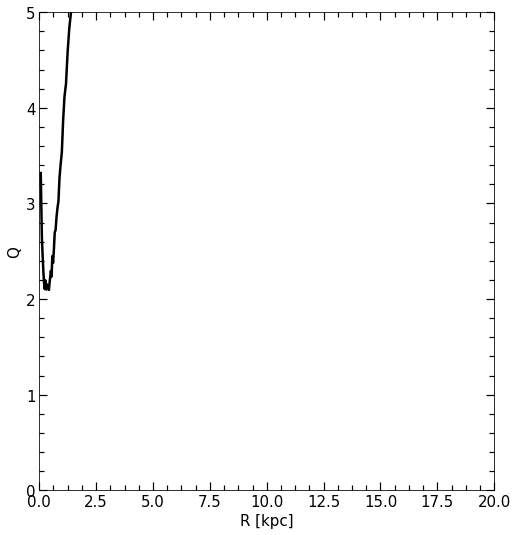

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))#,sharey=True
#                        gridspec_kw = {'height_ratios':[3,1,3,1]}
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)

ax.plot(rbin, Q,'-', lw=2.5, color='k')

ax.set_ylim(0,5)
ax.minorticks_on()
ax.tick_params( labelsize=15)
ax.tick_params('both', length=5, width=1.2,which='minor', direction='in', right=True,top=True)
ax.tick_params('both', length=8, width=1.2,which='major', direction='in', right=True,top=True)
ax.set_ylabel('Q',fontsize=15)
ax.set_xlabel('R [kpc]',fontsize=15)
ax.set_xlim(0,20)
# fig.savefig('/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/sigma_R.pdf', dpi = 100, xxbox_inches='tight')

plt.show()

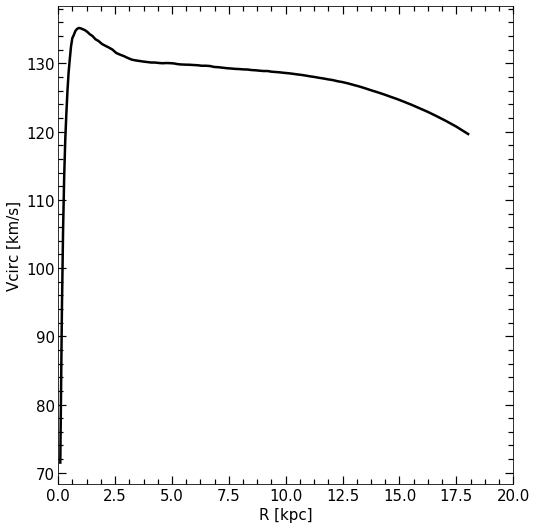

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))#,sharey=True
#                        gridspec_kw = {'height_ratios':[3,1,3,1]}
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)

ax.plot(r_vc, vc,'-', lw=2.5, color='k')

#  ax.set_ylim(0,5)
ax.minorticks_on()
ax.tick_params( labelsize=15)
ax.tick_params('both', length=5, width=1.2,which='minor', direction='in', right=True,top=True)
ax.tick_params('both', length=8, width=1.2,which='major', direction='in', right=True,top=True)
ax.set_ylabel('Vcirc [km/s]',fontsize=15)
ax.set_xlabel('R [kpc]',fontsize=15)
ax.set_xlim(0,20)
# fig.savefig('/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/sigma_R.pdf', dpi = 100, xxbox_inches='tight')

plt.show()

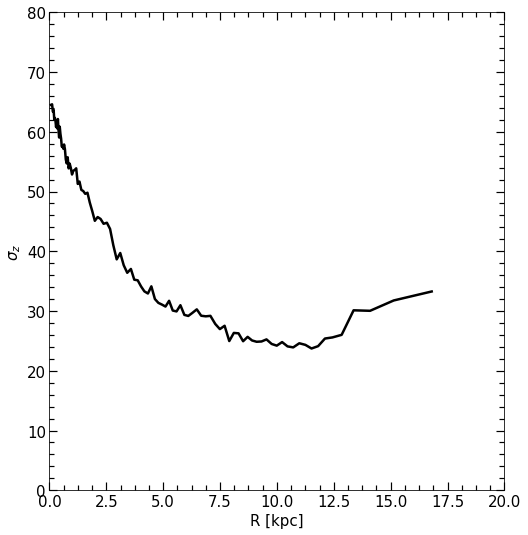

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))#,sharey=True
#                        gridspec_kw = {'height_ratios':[3,1,3,1]}
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)

ax.plot(rbin, sigma_z,'-', lw=2.5, color='k')

ax.minorticks_on()
ax.tick_params( labelsize=15)
ax.tick_params('both', length=5, width=1.2,which='minor', direction='in', right=True,top=True)
ax.tick_params('both', length=8, width=1.2,which='major', direction='in', right=True,top=True)
ax.set_ylabel('$\sigma_z$',fontsize=15)
ax.set_xlabel('R [kpc]',fontsize=15)
ax.set_xlim(0,20)
ax.set_ylim(0,80)
# fig.savefig('/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/sigma_R.pdf', dpi = 100, xxbox_inches='tight')

plt.show()

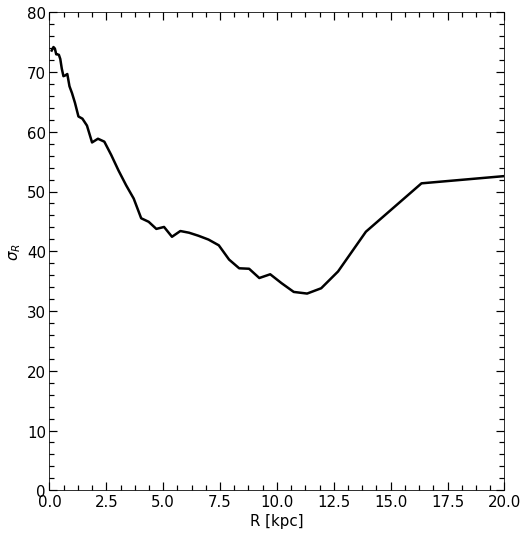

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))#,sharey=True
#                        gridspec_kw = {'height_ratios':[3,1,3,1]}
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)

ax.plot(rbin, sigma_R,'-', lw=2.5, color='k')

ax.minorticks_on()
ax.tick_params( labelsize=15)
ax.tick_params('both', length=5, width=1.2,which='minor', direction='in', right=True,top=True)
ax.tick_params('both', length=8, width=1.2,which='major', direction='in', right=True,top=True)
ax.set_ylabel('$\sigma_R$',fontsize=15)
ax.set_xlabel('R [kpc]',fontsize=15)
ax.set_xlim(0,20)
ax.set_ylim(0,80)
# fig.savefig('/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/sigma_R.pdf', dpi = 100, xxbox_inches='tight')

plt.show()

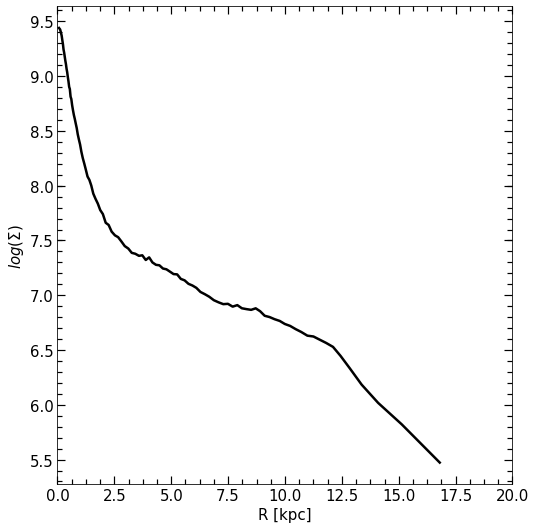

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))#,sharey=True
#                        gridspec_kw = {'height_ratios':[3,1,3,1]}
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)

ax.plot(rbin, np.log10(surf_den),'-', lw=2.5, color='k')

ax.minorticks_on()
ax.tick_params( labelsize=15)
ax.tick_params('both', length=5, width=1.2,which='minor', direction='in', right=True,top=True)
ax.tick_params('both', length=8, width=1.2,which='major', direction='in', right=True,top=True)
ax.set_ylabel('$log(\Sigma)$',fontsize=15)
ax.set_xlabel('R [kpc]',fontsize=15)
ax.set_xlim(0,20)
# fig.savefig('/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/sigma_R.pdf', dpi = 100, xxbox_inches='tight')

plt.show()

### For Gasoline

In [23]:
import h5py
import rotation_mio as rot
import time_conversion as tiempo
import bines2
import density as den
import circular_velocity as vcirc
import numpy as np

#Parámetros cosmológicos
#--------------------------------------------------------------------------
G = 4.299e-6
a0=1.
#---------------------------------------------------------------------------

vector = (1,2,4)
vector2 = ('r','M31', 'MW','r','M33')

path2 = '/home/omarioni/Barras_GdGs/Barras_Gd/_data/Toomre/test/'

path = '/mnt/sersic2/omarioni/'

snapshot = np.loadtxt(path + 'Gasoline/snapshots.txt', dtype='string')

halos = (1,2,4)
k =len(snapshot)-1
# for k in range(len(snapshot)-1,0,-1):

snap = h5py.File(path + 'Gasoline/outputs2/snap_'+str('%s'%snapshot[k])+'.h5py', 'r')
    
#     for i in halos:
i=4
cm   = snap['subhalo_00'+ str('%s' %i)+ '/Center'][()]
r200 = snap['subhalo_00'+ str('%s' %i)+ '/R200'][()]
time = snap['subhalo_00'+ str('%s' %i)+ '/Time'][()]
h    = snap['subhalo_00'+ str('%s' %i)+ '/h'][()]
aexp = snap['subhalo_00'+ str('%s' %i)+ '/aexp'][()]

pstr = snap['subhalo_00'+ str('%s' %i) + '/Str/Coordinates'][()]
mstr = snap['subhalo_00'+ str('%s' %i) + '/Str/Masses'][()]
vel  = snap['subhalo_00'+ str('%s' %i)+ '/Str/Velocities'][()]

pdrk = snap['subhalo_00'+ str('%s' %i) + '/Drk/Coordinates'][()]
mdrk = snap['subhalo_00'+ str('%s' %i) + '/Drk/Masses'][()]

pgas = snap['subhalo_00'+ str('%s' %i) + '/Gas/Coordinates'][()]
mgas = snap['subhalo_00'+ str('%s' %i) + '/Gas/Masses'][()]

#---aca paso las coordenadas respecto al centro de la galaxia------
xstr = pstr[:,0]-cm[0]
ystr = pstr[:,1]-cm[1]
zstr = pstr[:,2]-cm[2]
r = np.sqrt(xstr**2+ystr**2+zstr**2)

xdrk = pdrk[:,0]-cm[0]
ydrk = pdrk[:,1]-cm[1]
zdrk = pdrk[:,2]-cm[2]

xgas = pgas[:,0]-cm[0]
ygas = pgas[:,1]-cm[1]
zgas = pgas[:,2]-cm[2]
#----------------------masas----------------------------
rgal=0.15*r200*aexp

limit = np.where(r<rgal)
r_sort = np.sort(r[limit])
r_indice = np.argsort(r[limit])


Mc_str = np.cumsum((mstr[limit])[r_indice])
M_gal = Mc_str[-1]

#------------------ calculamos M90------------------------------------------
razon = Mc_str/M_gal
noventa, = np.where(razon < 0.9)
cincuenta, = np.where(razon < 0.5)

r50 = r_sort[cincuenta][-1]
#         M90 = Mc_str[noventa]                

#-------------------------------------------------------------------            
veloc,=np.where(r<r50)

#----------componentes de la velocidad del centro de masa------------
vxcm = sum(mstr[veloc]*vel[veloc,0])/sum(mstr[veloc])
vycm = sum(mstr[veloc]*vel[veloc,1])/sum(mstr[veloc])
vzcm = sum(mstr[veloc]*vel[veloc,2])/sum(mstr[veloc])


#----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
vx = vel[:,0] - vxcm
vy = vel[:,1] - vycm
vz = vel[:,2] - vzcm

e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp)

xn = e1x*xstr + e1y*ystr + e1z*zstr
yn = e2x*xstr + e2y*ystr + e2z*zstr
zn = e3x*xstr + e3y*ystr + e3z*zstr
vxn = e1x*vx + e1y*vy + e1z*vz
vyn = e2x*vx + e2y*vy + e2z*vz
vzn = e3x*vx + e3y*vy + e3z*vz

rn = np.sqrt(xn**2 + yn**2 + zn**2)

#----------calculamos las dispersiones de velocidades---------------------
corte1, = np.where(rn < 15)
#     corte_bin2, = np.where(rn < 6.)

R = np.sqrt(xn[corte1]**2 + yn[corte1]**2)

nbin = 50 #20
rbin, nodos = bines2.rbin1(R, nbin)

Vr = (xn[corte1]*vxn[corte1] + yn[corte1]*vyn[corte1])/R
Vz = vzn[corte1]
Vt = (xn[corte1]*vyn[corte1] - yn[corte1]*vxn[corte1])/R

sigma_z = np.zeros(nbin)
sigma_R = np.zeros(nbin)
sigma_t = np.zeros(nbin)


for j in range(nbin):
    mask, = np.where((nodos[j] < R) & (nodos[j+1] > R))
    n = len(mask)
    Vz_mean = np.mean(Vz[mask])
    Vr_mean = np.mean(Vr[mask])
    Vt_mean = np.mean(Vt[mask])

    sigma_z[j] = np.sqrt(sum((Vz[mask] - Vz_mean)**2)/n)
    sigma_R[j] = np.sqrt(sum((Vr[mask] - Vr_mean)**2)/n)
    sigma_t[j] = np.sqrt(sum((Vt[mask] - Vt_mean)**2)/n)


surf_den, rden = den.surf_density(R,mstr[corte1],nbin)

xngas = e1x*xgas + e1y*ygas + e1z*zgas
yngas = e2x*xgas + e2y*ygas + e2z*zgas
zngas = e3x*xgas + e3y*ygas + e3z*zgas
rgas  = np.sqrt(xngas**2 + yngas**2 + zngas**2)
Rgas  = np.sqrt(xngas**2 + yngas**2)

xndrk = e1x*xdrk + e1y*ydrk + e1z*zdrk
yndrk = e2x*xdrk + e2y*ydrk + e2z*zdrk
zndrk = e3x*xdrk + e3y*ydrk + e3z*zdrk
rdrk  = np.sqrt(xndrk**2 + yndrk**2 + zndrk**2)
Rdrk  = np.sqrt(xndrk**2 + yndrk**2)

corte_gas = np.where(rgas < 15)
corte_drk = np.where(rdrk < 15)

Rtot= np.concatenate([R, Rgas[corte_gas], Rdrk[corte_drk]])
mtot= np.concatenate([mstr[corte1], mgas[corte_gas], mdrk[corte_drk]])

vc, r_vc = vcirc.Vc_bin(Rtot, mtot, nbin)

Q, kappa = tommre(rbin, vc, sigma_R, surf_den)

data = np.ndarray([nbin,8])
data[:,0] = rbin
data[:,1] = sigma_z
data[:,2] = sigma_R
data[:,3] = sigma_t
data[:,4] = surf_den
data[:,5] = vc
data[:,6] = Q
data[:,7] = kappa

np.savetxt(path2 + 'M33GS_test_toomre.dat',data, fmt='%12.6f')

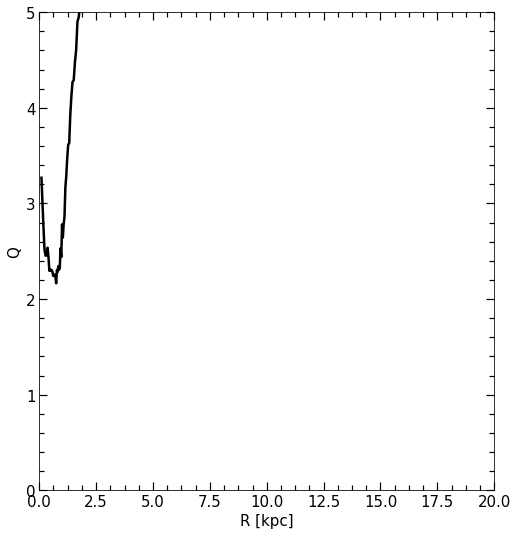

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))#,sharey=True
#                        gridspec_kw = {'height_ratios':[3,1,3,1]}
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)

ax.plot(rbin, Q,'-', lw=2.5, color='k')

ax.set_ylim(0,5)
ax.minorticks_on()
ax.tick_params( labelsize=15)
ax.tick_params('both', length=5, width=1.2,which='minor', direction='in', right=True,top=True)
ax.tick_params('both', length=8, width=1.2,which='major', direction='in', right=True,top=True)
ax.set_ylabel('Q',fontsize=15)
ax.set_xlabel('R [kpc]',fontsize=15)
ax.set_xlim(0,20)
# fig.savefig('/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/sigma_R.pdf', dpi = 100, xxbox_inches='tight')

plt.show()

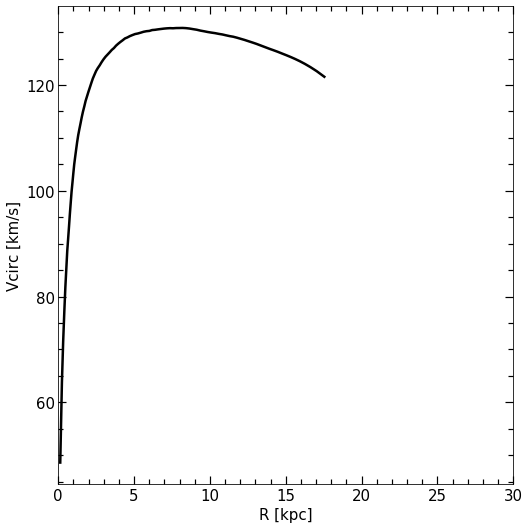

In [12]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))#,sharey=True
#                        gridspec_kw = {'height_ratios':[3,1,3,1]}
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)

ax.plot(r_vc, vc,'-', lw=2.5, color='k')

#  ax.set_ylim(0,5)
ax.minorticks_on()
ax.tick_params( labelsize=15)
ax.tick_params('both', length=5, width=1.2,which='minor', direction='in', right=True,top=True)
ax.tick_params('both', length=8, width=1.2,which='major', direction='in', right=True,top=True)
ax.set_ylabel('Vcirc [km/s]',fontsize=15)
ax.set_xlabel('R [kpc]',fontsize=15)
ax.set_xlim(0,30)
# fig.savefig('/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/sigma_R.pdf', dpi = 100, xxbox_inches='tight')

plt.show()

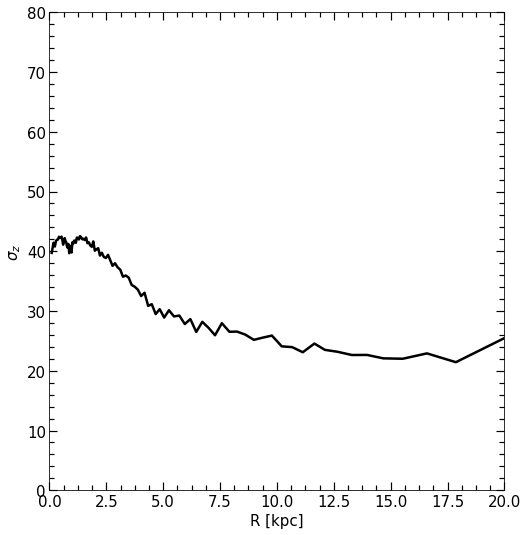

In [47]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))#,sharey=True
#                        gridspec_kw = {'height_ratios':[3,1,3,1]}
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)

ax.plot(rbin, sigma_z,'-', lw=2.5, color='k')

ax.minorticks_on()
ax.tick_params( labelsize=15)
ax.tick_params('both', length=5, width=1.2,which='minor', direction='in', right=True,top=True)
ax.tick_params('both', length=8, width=1.2,which='major', direction='in', right=True,top=True)
ax.set_ylabel('$\sigma_z$',fontsize=15)
ax.set_xlabel('R [kpc]',fontsize=15)
ax.set_xlim(0,20)
ax.set_ylim(0,80)
# fig.savefig('/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/sigma_R.pdf', dpi = 100, xxbox_inches='tight')

plt.show()


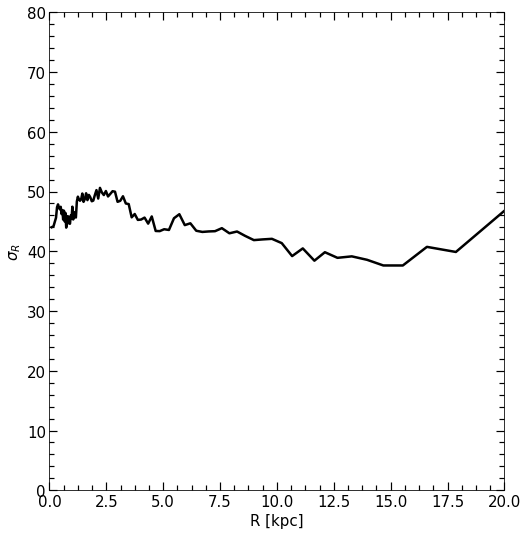

In [48]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))#,sharey=True
#                        gridspec_kw = {'height_ratios':[3,1,3,1]}
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)

ax.plot(rbin, sigma_R,'-', lw=2.5, color='k')

ax.minorticks_on()
ax.tick_params( labelsize=15)
ax.tick_params('both', length=5, width=1.2,which='minor', direction='in', right=True,top=True)
ax.tick_params('both', length=8, width=1.2,which='major', direction='in', right=True,top=True)
ax.set_ylabel('$\sigma_R$',fontsize=15)
ax.set_xlabel('R [kpc]',fontsize=15)
ax.set_xlim(0,20)
ax.set_ylim(0,80)
# fig.savefig('/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/sigma_R.pdf', dpi = 100, xxbox_inches='tight')

plt.show()

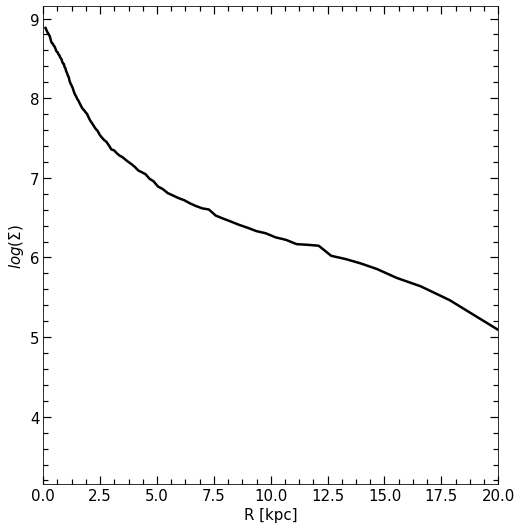

In [50]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))#,sharey=True
#                        gridspec_kw = {'height_ratios':[3,1,3,1]}
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)

ax.plot(rbin, np.log10(surf_den),'-', lw=2.5, color='k')

ax.minorticks_on()
ax.tick_params( labelsize=15)
ax.tick_params('both', length=5, width=1.2,which='minor', direction='in', right=True,top=True)
ax.tick_params('both', length=8, width=1.2,which='major', direction='in', right=True,top=True)
ax.set_ylabel('$log(\Sigma)$',fontsize=15)
ax.set_xlabel('R [kpc]',fontsize=15)
ax.set_xlim(0,20)
# fig.savefig('/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/sigma_R.pdf', dpi = 100, xxbox_inches='tight')

plt.show()